In [1]:
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from regions import Regions, PixCoord,RectanglePixelRegion, CirclePixelRegion
from astropy import stats
from itertools import chain
import dendrocat
from astropy import units as u
from astropy.table import Table
import matplotlib as mpl
import astropy.units as u
from radio_beam import Beam
import time
import astropy.constants as c
import matplotlib.colors as colors

#importlib.reload(dendrocat)
W51b6 = '/orange/adamginsburg/w51/TaehwaYoo/2015.1.01596.S_W51_B6_LB/continuum_images/'
W51cont='/orange/adamginsburg/w51/TaehwaYoo/b6contfits/'
w51e2_b6_briggs=W51cont+'W51e2_cont_bigbriggs.image.fits'
w51e2_b6_robust0=W51cont+'W51e2_cont_big_robust0.image.fits'
w51e2_b6_uniform=W51cont+'W51e2_cont_biguniform.image.fits'
w51e2_b6_superuniform=W51cont+'W51e2_cont_bigsuperuniform.image.fits'

w51n_b6_briggs = W51cont+'W51n_cont_bigbriggs.image.fits'
w51n_b6_robust0 = W51cont+'w51n_cont_big_robust0.image.fits'
w51n_b6_uniform = W51cont+'W51n_cont_biguniform.image.fits'
w51n_b6_superuniform = W51cont+'W51n_cont_bigsuperuniform.image.fits'
w51n_b6_natural = W51cont+'W51n_cont_bignatural.image.fits'

W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'
w51e_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'
w51n_b6_conv_briggs = w51conv + 'w51n_briggs_B6_conv.fits'
w51n_b6_conv_robust0 = w51conv + 'w51n_robust0_B6_conv.fits'
w51n_b6_conv_superuniform = w51conv + 'w51n_superuniform_B6_conv.fits'

w51e_b6_conv_briggs = w51conv + 'w51e_briggs_B6_conv.fits'
w51e_b6_conv_robust0 = w51conv + 'w51e_robust0_B6_conv.fits'
w51e_b6_conv_superuniform = w51conv + 'w51e_superuniform_B6_conv.fits'

w51e_b6_calibrated2 = '/orange/adamginsburg/w51/alma/TaehwaYoo/w51_b6_e2_selfcal_tyoo_cont_20230822/w51e2.spw0thru19.14500.robust0.thr0.1mJy.mfs.I.startmod.selfcal6.image.tt0.fits'
w51e_b6_calibrated = '/orange/adamginsburg/w51/TaehwaYoo/w51e2.spw0thru19.14500.robust0.thr0.15mJy.mfs.I.startmod.selfcal7.image.tt0.fits'
w51n_b6_calibrated = '/orange/adamginsburg/w51/TaehwaYoo/w51n.spw0thru19.14500.robust0.thr0.1mJy.mfs.I.startmod.selfcal7.image.tt0.fits'

w51e_b6_noise = '/orange/adamginsburg/w51/TaehwaYoo/w51e_b6_std_sky_new.reg'
w51e_b3_noise = '/orange/adamginsburg/w51/TaehwaYoo/w51e_b3_std_sky_new.reg'
w51n_b6_noise = '/orange/adamginsburg/w51/TaehwaYoo/w51n_b6_std_sky_new.reg'
w51n_b3_noise = '/orange/adamginsburg/w51/TaehwaYoo/w51n_b3_std_sky_new.reg'

w51e_b6_calibrated_pbcor = '/orange/adamginsburg/w51/TaehwaYoo/w51e2.spw0thru19.14500.robust0.thr0.15mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b6_calibrated_pbcor = '/orange/adamginsburg/w51/TaehwaYoo/w51n.spw0thru19.14500.robust0.thr0.1mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'

photometrydir = '/home/t.yoo/w51/catalogue/photometry/'
w51e_b3_flux = photometrydir+'w51e_b3_flux_size.fits'
w51n_b3_flux = photometrydir+'w51n_b3_flux_size.fits'
w51e_b6_flux = photometrydir+'w51e_b6_flux_size.fits'
w51n_b6_flux = photometrydir+'w51n_b6_flux_size.fits'

w51e_matched_catalog = '/home/t.yoo/w51/catalogue/dendrogram/dendro_w51e_matched.fits'
w51n_matched_catalog = '/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_matched.fits'


In [2]:

def gaussian2d(x, y, x_center=0, y_center=0, theta=0, sigma_x = 10, sigma_y=10,norm=1):
    # x_center and y_center will be the center of the gaussian, theta will be the rotation angle
    # sigma_x and sigma_y will be the stdevs in the x and y axis before rotation
    # x_size and y_size give the size of the frame 

    #theta = 2*np.pi*theta/360
   # x = np.arange(0,x_size, 1, float)
   # y = np.arange(0,y_size, 1, float)
    
   # y = y[:,np.newaxis]

    theta = 180*u.deg - theta
    sx = sigma_x
    sy = sigma_y
    x0 = x_center
    y0 = y_center

    # rotation
    a=np.cos(theta)*x -np.sin(theta)*y
    b=np.sin(theta)*x +np.cos(theta)*y
    a0=np.cos(theta)*x0 -np.sin(theta)*y0
    b0=np.sin(theta)*x0 +np.cos(theta)*y0

    return norm*np.exp(-(((a-a0)**2)/(2*(sx**2)) + ((b-b0)**2) /(2*(sy**2))))

def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)

def get_flux_from_mass(mass, freq, temp=50*u.K, dist=5.41*u.kpc):
    BB = 2 *np.pi * c.h * freq**3 / (c.c**2) / (np.e**(c.h*freq/(c.k_B*temp)) - 1)
    kappa_freq = kappa(freq)
    flux = mass / dist**2 * BB * kappa_freq 
    return flux.to(u.Jy)

def get_peak_from_flux(flux, sigma_x, sigma_y, beam, pixel_scale):
    
    norm = flux.to(u.Jy) /(2*np.pi) * (np.pi * beam.major/2 * beam.minor/2) / (pixel_scale.to(u.deg))**2 /sigma_x/sigma_y
    
    return norm.to(u.Jy).value

def BB(freq, temp):
    B_nu = (2 * freq**3 *c.h / (c.c**2) * 1 / (np.e**(c.h*freq/(c.k_B*temp))-1))
    return B_nu 

def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down*u.Hz
def get_noise(noisefile, wcs, image):
    noiseregion = Regions.read(noisefile,format='ds9')

    container = []
    for reg in noiseregion:
        pix_reg = reg.to_pixel(wcs)
        noisemask = pix_reg.to_mask()
        noiseim = noisemask.cutout(image)

        container.append(noiseim.flatten())
    noiseim = np.concatenate(container)
    std = stats.mad_std(noiseim,ignore_nan=True)
    return std

def get_rad_fov(image, wcs_image, image_transform, wcs_transform):
    ycenter = int(image.shape[0]/2)
    center_col = image[ycenter,:]
    
    edge = np.max(np.where(np.isfinite(center_col))[0])
#    center_skycoords = wcs_image.pixel_to_world(image.shape[1]/2,image.shape[0]/2)
    edge_skycoords = wcs_image.pixel_to_world(edge,image.shape[0]/2)
    edge_pixcoord_transform = wcs_transform.world_to_pixel(edge_skycoords)
    rad = edge_pixcoord_transform[0] - image_transform.shape[1]/2

    return rad
    
def make_mock_obs(image, YSO_xypos, pa, sig_major, sig_minor, peak, gridsize=100, rad=20000):
    start =time.time()
    yy,xx = np.mgrid[:gridsize,:gridsize]
    img_center = image.shape[0]/2
    model = gaussian2d(xx, yy, x_center=gridsize/2, y_center=gridsize/2
                           , theta=pa, sigma_x = sig_major, sigma_y=sig_minor,norm=peak)
    model = np.array(model)
    rep_num = int(image.shape[0]/gridsize)
    mock_obs_set = np.tile(model, (rep_num,rep_num))

    xcoord_big = np.array([int(YSO_xypos[i,0]/gridsize) for i in range(len(YSO_xypos[:,0]))])
    ycoord_big = np.array([int(YSO_xypos[i,1]/gridsize) for i in range(len(YSO_xypos[:,1]))])
    
    arr_for_count = np.ones((rep_num,rep_num))
    for i in range(len(xcoord_big)):
        xcen = (2*xcoord_big[i]+1)*gridsize/2
        ycen = (2*ycoord_big[i]+1)*gridsize/2

        reg = RectanglePixelRegion(center=PixCoord(x=xcen, y=ycen),
                                  width=gridsize, height=gridsize,
                                  )
        mask = reg.to_mask()
        mask_img = mask.to_image(mock_obs_set.shape)
        mask_img_inv = np.ones(mock_obs_set.shape)-mask_img
        
        
        mock_obs_set = mock_obs_set * mask_img_inv
        
        
        arr_for_count[ycoord_big[i], xcoord_big[i]]=0
    
    reg = CirclePixelRegion(center=PixCoord(x=img_center, y=img_center), radius=rad)
    mask = reg.to_mask()
    mask_img = mask.to_image(mock_obs_set.shape)

    mock_obs_set = mock_obs_set * mask_img

    
    reg_for_count = CirclePixelRegion(center=PixCoord(x=arr_for_count.shape[1]/2, y=arr_for_count.shape[0]/2), 
                                      radius=rad/gridsize)
    mask = reg_for_count.to_mask(mode='exact')
    mask_img = mask.to_image(arr_for_count.shape)
    mask_img[np.where(mask_img<1)]=0

    count_arr = arr_for_count * mask_img
    print('number of synthetic sources, ', len(np.where(count_arr==1)[0]))
    print('make_mock_obs, ', time.time()-start)
    
    return image + mock_obs_set, count_arr

def plot_peak(ax,image,source_object,custom_dendro,size=20,colorarr=['cyan','r'],xoffset=0,yoffset=0,plot_accepted=True,labelind=None,labeltext=None):
    
    structure = np.array(custom_dendro.leaves)
    table = source_object.catalog
    rejected_ind= table['rejected'].value
    accepted = np.where(rejected_ind==0)[0]
    rejected = np.where(rejected_ind==1)[0]
    indicator=table['_name']
    if plot_accepted:
        st =[structure[accepted]]
        indicator=[table['_name'][accepted]]
    else:
        st = [ structure[rejected],structure[accepted]]
        indicator= [ table['_name'][rejected],table['_name'][accepted]]
    #if objind is not None:
    #    structure = structure[objind]
    print('accepted source num',len(accepted))
    xarr = []; yarr=[] ; peakvalarr=[]

    for j, struct in enumerate(st):
        indic = indicator[j]
        for i, s in enumerate(struct):
            
            xind = s.indices(subtree=True)[0]
            yind = s.indices(subtree=True)[1]

            value = s.values(subtree=True)
            xpos = yind[np.argmax(value)]+xoffset
            ypos = xind[np.argmax(value)]+yoffset
            
            ax.scatter(xpos,ypos, marker='x', c=colorarr[j],s=size)
            if labelind is None:
              #  ax.text(xpos-20,ypos+20,'w51n_%d'%i,color='w',fontsize=15)
            
                if labeltext is None:
                    ax.text(xpos-20,ypos+20,'%s'%(indic[i]),color='w',fontsize=15)
              #  else:
              #      ax.text(xpos-20,ypos+20,'%s_%d'%(labeltext,labelind[i]),color='w',fontsize=15)
              #  if labelind is None:
              #      ax.text(xpos-20,ypos+20,'w51n_%d'%i,color='w',fontsize=15)
              #  else:
              #      ax.text(xpos-20,ypos+20,'%3.2f'%labelind[i],color='w',fontsize=15)

            maxval = np.max(value)
            xarr.append(xpos) ; yarr.append(ypos) ; peakvalarr.append(maxval)
    
    return np.vstack((xarr,yarr)).T, peakvalarr, xarr, yarr

def get_detection_rate(xcenarr, ycenarr, peakxy, threshold=5):
    isdetect_arr=[]
    for xcen, ycen in zip(xcenarr,ycenarr):
        dist = np.sqrt((xcen-peakxy[:,0])**2+(ycen-peakxy[:,1])**2)
        if np.min(dist)<threshold:
            isdetect_arr.append(True)
        else:
            isdetect_arr.append(False)
    
    return isdetect_arr

def add_mask_on_source(image, xpos,ypos,rad=50, gridsize=500):
    start = time.time()
    
    total_mask = np.zeros((image.shape))
    for x, y in zip(xpos,ypos):
        reg = CirclePixelRegion(center=PixCoord(x=(x+0.5)*gridsize, y=(y+0.5)*gridsize), radius=rad)
        mask = reg.to_mask()
        mask_img = mask.to_image(image.shape)
        total_mask = total_mask + mask_img
    if np.max(total_mask)>1:
        print(np.max(total_mask))
        raise ValueError('mask regions overlap!')
    print('add_mask_on_source finished, ', time.time()-start )
    return image * total_mask


def main(fitsfile, noisefile, b6fits, fluxfile_fits, ysocatalogfile, min_value_factor = 3, min_delta_factor = 1.5, min_npix = 15, dist=5.41*u.kpc, gridsize=100):
    
    fitsdata = fits.open(fitsfile)
    noiseregion= Regions.read(noisefile,format='ds9')
    image = fitsdata[0].data
    if len(image.shape)>2:
        image = fitsdata[0].data[0][0]
    wcs = WCS(fitsdata[0].header,naxis=2)
    
    noiselevel = get_noise(noisefile, wcs, image)
    header = fitsdata[0].header
    
    scale = wcs.proj_plane_pixel_scales()[0]

    # in pix scale, fwhm -> sigma
    # B3 fluxfile
    fluxfile = Table.read(fluxfile_fits)

    majind = np.where(fluxfile['fitted_major']>0)
    minind = np.where(fluxfile['fitted_minor']>0)
    major_median = np.median(fluxfile['fitted_major'][majind]/scale)/np.sqrt(8*np.log(2))
    minor_median = np.median(fluxfile['fitted_minor'][minind]/scale)/np.sqrt(8*np.log(2))

    beam = Beam.from_fits_header(header)
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    masses = np.linspace(0.05,1,11)*u.Msun
    
    completeness_arr = []
    fitsdata_b6 = fits.open(b6fits)
    image_b6 = fitsdata_b6[0].data
    if len(image_b6.shape)>2:
        image_b6 = fitsdata_b6[0].data[0][0]
    wcs_b6 = WCS(fitsdata_b6[0].header,naxis=2)
    
    # only get the samples of B3 inside of B6 FoV
    rad = get_rad_fov(image_b6, wcs_b6, image, wcs) 
    
    
    ysocatalog = Table.read(ysocatalogfile)
    YSO_xypos = np.vstack((ysocatalog['b3_xpix'], ysocatalog['b3_ypix'])).T
    #print(YSO_xypos.shape)

    ysoind = np.where(ysocatalog['b3_xpix']>0)[0]
    #print('ysoind',ysoind)
    YSO_xypos = YSO_xypos[ysoind,:]
    if band=='b3':
        freq =freqb3
    else:
        freq =freqb6
    #print(YSO_xypos.shape)
    for mass in masses:
        print('mass, ', mass)
        flux = get_flux_from_mass(mass,freq,dist=dist)  
        print('flux, ', flux)
        peak = get_peak_from_flux(flux, major_median, minor_median, beam, scale)   
        print('peak, ', peak)
        image_synth, countarr = make_mock_obs(image, YSO_xypos, beam.pa+90*u.deg,  major_median, minor_median, peak, gridsize=gridsize, rad=rad)
        fig = plt.figure(figsize=(120,120))
        ax1 = fig.add_axes([0,0,1,1])
        ax1.imshow(image_synth, origin='lower',cmap=plt.get_cmap('inferno'),
           norm=colors.PowerNorm(gamma=0.5,vmin=-0.0002931984323361649,vmax=0.011008596484193698))

        plt.show()
        plt.close()
        print(image_synth)
        print(type(image_synth))
        ypos, xpos = np.where(countarr==1)
        print(xpos,ypos)
        image_synth = add_mask_on_source(image_synth, xpos,ypos,rad=50, gridsize=gridsize) #rad should be smaller than gridsize
        start=time.time()
        source_object = RadioSource(im=image_synth, header=header)
        custom_dendro = source_object.to_dendrogram(min_value=min_value_factor*noiselevel, 
                                                  min_delta=min_delta_factor*noiselevel, 
                                                  min_npix=min_npix)
        
        tab = source_object.to_catalog()
        print('dendrogram, ', time.time()-start)
        fig = plt.figure(figsize=(120,120))
        ax1 = fig.add_axes([0,0,1,1])
        ax1.imshow(image_synth, origin='lower',cmap=plt.get_cmap('inferno'),
           norm=colors.PowerNorm(gamma=0.5,vmin=-0.0002931984323361649,vmax=0.011008596484193698))
        peakxy,peakval,xarr,yarr = plot_peak(ax1,image,source_object,custom_dendro,size=40,plot_accepted=False)

        plt.show()
        plt.close()
        
        ycen, xcen = np.where(countarr==1)
        isdetect_arr = get_detection_rate((xcen+0.5)*gridsize, (ycen+0.5)*gridsize, peakxy)
        
        completeness = len(np.where(isdetect_arr)[0])/len(isdetect_arr)
        print('completeness, ',completeness)
        completeness_arr.append(completeness)
    print('final product, ',completeness_arr)
    return completeness_arr

        
        
        
       



In [3]:
#w51n_completeness = main(w51n_b3_tt0, w51n_b3_noise, w51n_b6_calibrated_pbcor, w51n_b3_flux, w51n_matched_catalog)


In [4]:
#w51e_completeness = main(w51e_b3_tt0, w51e_b3_noise, w51e_b6_calibrated_pbcor, w51e_b3_flux, w51e_matched_catalog)




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

0.00024625859163505465 0.00020479120966650853
0.0011969557023590429 0.0013186214013947485


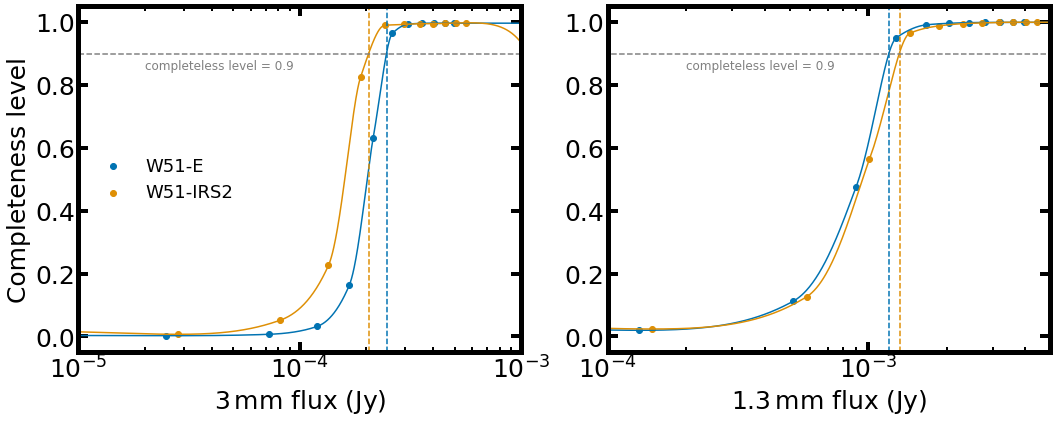

In [24]:
from scipy.interpolate import pchip_interpolate
import seaborn as sns
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)

cmap = sns.color_palette("colorblind")

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_axes([0.08,0.15,0.41,0.8])
ax2 = fig.add_axes([0.57,0.15,0.41,0.8])

masses = np.linspace(0.05,1,11)*u.Msun

w51e_completeness_file = '/home/t.yoo/job/completeness/w51e_b3_completeness.txt'
w51n_completeness_file = '/home/t.yoo/job/completeness/w51n_b3_completeness.txt'

w51e_completeness_data = np.loadtxt(w51e_completeness_file)
w51n_completeness_data = np.loadtxt(w51n_completeness_file)

w51e_completeness = w51e_completeness_data[:,0]
w51n_completeness = w51n_completeness_data[:,0]
w51e_flux = w51e_completeness_data[:,1]
w51n_flux = w51n_completeness_data[:,1]

ax1.scatter(w51e_flux, w51e_completeness, marker='o', c=cmap[0],label='W51-E')
ax1.scatter(w51n_flux, w51n_completeness, marker='o', c=cmap[1], label='W51-IRS2')
xarr = np.logspace(-5,-3,1000)
w51e_interp = pchip_interpolate(w51e_flux, w51e_completeness,xarr )
w51n_interp = pchip_interpolate(w51n_flux, w51n_completeness,xarr )
ax1.plot(xarr, w51e_interp, c=cmap[0])
ax1.plot(xarr, w51n_interp, c=cmap[1])
ind_w51e = np.argmin(np.abs(w51e_interp-0.9))
ind_w51n = np.argmin(np.abs(w51n_interp-0.9))
print(xarr[ind_w51e], xarr[ind_w51n])
ax1.plot([xarr[ind_w51e],xarr[ind_w51e]],[-0.1,1.1],ls='dashed', c=cmap[0])
ax1.plot([xarr[ind_w51n],xarr[ind_w51n]],[-0.1,1.1],ls='dashed', c=cmap[1])

w51e_b3_completeness = xarr[ind_w51e]
w51n_b3_completeness = xarr[ind_w51n]

ax1.plot([-0.01,1.01],[0.9,0.9], c='gray',ls='dashed')
ax1.text(2e-5,0.85, 'completeless level = 0.9', c='gray', fontsize=12)
#ax1.text(1.5e-4,0.05,'%3.2e Jy'%xarr[ind_w51n], c='orange',fontsize=15)
#ax1.text(3e-4,0.05,'%3.2e Jy'%xarr[ind_w51e], c='b',fontsize=15)
w51e_completeness_file = '/home/t.yoo/job/completeness/w51e_b6_completeness.txt'
w51n_completeness_file = '/home/t.yoo/job/completeness/w51n_b6_completeness.txt'

w51e_completeness_data = np.loadtxt(w51e_completeness_file)
w51n_completeness_data = np.loadtxt(w51n_completeness_file)

w51e_completeness = w51e_completeness_data[:,0]
w51n_completeness = w51n_completeness_data[:,0]
w51e_flux = w51e_completeness_data[:,1]
w51n_flux = w51n_completeness_data[:,1]

ax2.scatter(w51e_flux, w51e_completeness, marker='o', c=cmap[0],label='W51-E')
ax2.scatter(w51n_flux, w51n_completeness, marker='o', c=cmap[1], label='W51-IRS2')
xarr = np.logspace(-5,-2,1000)
w51e_interp = pchip_interpolate(w51e_flux, w51e_completeness,xarr )
w51n_interp = pchip_interpolate(w51n_flux, w51n_completeness,xarr )
ax2.plot(xarr, w51e_interp, c=cmap[0])
ax2.plot(xarr, w51n_interp, c=cmap[1])
ind_w51e = np.argmin(np.abs(w51e_interp-0.9))
ind_w51n = np.argmin(np.abs(w51n_interp-0.9))
print(xarr[ind_w51e], xarr[ind_w51n])
ax2.plot([xarr[ind_w51e],xarr[ind_w51e]],[-0.1,1.1],ls='dashed', c=cmap[0])
ax2.plot([xarr[ind_w51n],xarr[ind_w51n]],[-0.1,1.1],ls='dashed', c=cmap[1])
w51e_b6_completeness = xarr[ind_w51e]
w51n_b6_completeness = xarr[ind_w51n]

ax2.plot([-0.01,1.01],[0.9,0.9], c='gray',ls='dashed')

ax1.legend(fontsize=18,frameon=False)
ax1.set_ylabel('Completeness level')
ax1.set_xlabel(r'$3\,{\rm mm}$ flux (Jy)')
ax2.set_xlabel(r'$1.3\,{\rm mm}$ flux (Jy)')

ax1.set_ylim(-0.05,1.05)
ax2.text(2e-4,0.85, 'completeless level = 0.9', c='gray', fontsize=12)
#ax2.text(8e-4,0.01,'%3.2e Jy'%xarr[ind_w51n], c='orange',fontsize=15)
#ax2.text(2e-3,0.01,'%3.2e Jy'%xarr[ind_w51e], c='b',fontsize=15)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim(1e-5,1e-3)
ax2.set_xlim(1e-4,5e-3)
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)

plt.savefig('completeness_b3.png')

In [64]:
def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down
def b6_to_b3flux(b6flux, si, b3freq, b6freq):
    return 10**(si*np.log(b3freq/b6freq))*b6flux
hdrNB6 = fits.getheader(w51e_b6_calibrated_pbcor)  
hdrNB3 = fits.getheader(w51e_b3_tt0)  
b3freq = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
b6freq = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])


catalog_w51e_yso = Table.read(w51e_matched_catalog ,format='fits')
catalog_w51n_yso = Table.read(w51n_matched_catalog ,format='fits')

w51e_temp = catalog_w51e_yso['temp']
w51n_temp = catalog_w51n_yso['temp']


w51e_percentile_temp = np.nanpercentile(w51e_temp.compressed(),[16,50,84] )
w51n_percentile_temp = np.nanpercentile(w51n_temp.compressed(),[16,50,84] )
print(w51e_percentile_temp)
w51e_b6_completeness2 = b6_to_b3flux(w51e_b6_completeness, 2,b3freq,b6freq)
w51e_b6_completeness37 = b6_to_b3flux(w51e_b6_completeness, 3.7,b3freq,b6freq)
w51n_b6_completeness2 = b6_to_b3flux(w51n_b6_completeness, 2,b3freq,b6freq)
w51n_b6_completeness37 = b6_to_b3flux(w51n_b6_completeness, 3.7,b3freq,b6freq)

def get_flux_from_mass(mass, freq, temp=50*u.K, dist=5.41*u.kpc):
    BB = 2 *np.pi * c.h * freq**3 / (c.c**2) / (np.e**(c.h*freq/(c.k_B*temp)) - 1)
    kappa_freq = kappa(freq)
    flux = mass / dist**2 * BB * kappa_freq 
    return flux.to(u.Jy)





[ 17.53544512  36.16260254 148.61477546]


[1.53265262 0.69460994 0.16121442]
[0.12356913 0.05313875 0.03623111]


(15.0, 160.0)

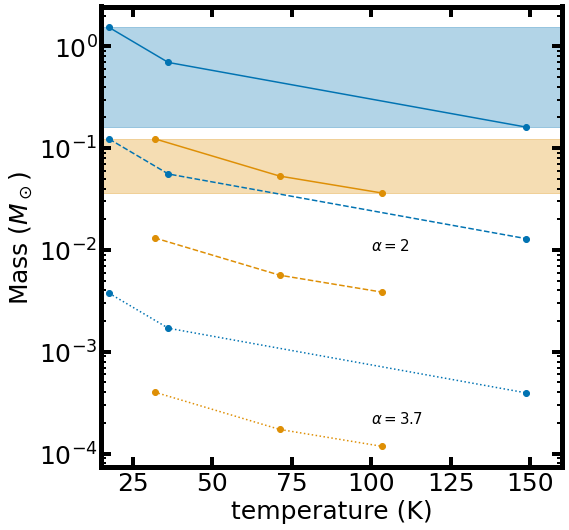

In [79]:
def get_mass(flux, kappa, freq,temp=50*u.K, dist=5.41*u.kpc, verbose=False):
    BB = 2 *np.pi * c.h * freq**3 / (c.c**2) / (np.e**(c.h*freq/(c.k_B*temp)) - 1)
    mass = flux * dist**2 / BB / kappa
    if verbose:
        print('ho')
        print(dist**2 / BB / kappa)
        print(flux)
        print(mass.to(u.Msun))
    return mass.to(u.Msun)
b3kappa = kappa(b3freq*u.Hz)
b6kappa = kappa(b6freq*u.Hz)
w51e_b3_completeness_mass = get_mass(w51e_b3_completeness*u.Jy, b3kappa,b3freq*u.Hz, temp=w51e_percentile_temp *u.K) 
w51n_b3_completeness_mass = get_mass(w51n_b3_completeness*u.Jy, b6kappa,b3freq*u.Hz, temp=w51n_percentile_temp *u.K, dist=5.1*u.kpc)

w51e_b6_completeness_mass2 = get_mass(w51e_b6_completeness2*u.Jy, b3kappa,b3freq*u.Hz, temp=w51e_percentile_temp *u.K) 
w51n_b6_completeness_mass2 = get_mass(w51n_b6_completeness2*u.Jy, b6kappa,b3freq*u.Hz, temp=w51n_percentile_temp *u.K, dist=5.1*u.kpc)

w51e_b6_completeness_mass37 = get_mass(w51e_b6_completeness37*u.Jy, b3kappa,b3freq*u.Hz, temp=w51e_percentile_temp *u.K) 
w51n_b6_completeness_mass37 = get_mass(w51n_b6_completeness37*u.Jy, b6kappa,b3freq*u.Hz, temp=w51n_percentile_temp *u.K, dist=5.1*u.kpc)
#w51e_b3_completeness_mass_lowtemp = get_flux_from_mass(w51e_b3_completeness*u.Msun, b3freq*u.Hz, temp=w51e_percentile_temp[0] *u.K) 
#w51n_b3_completeness_mass_lowtemp = get_flux_from_mass(w51n_b3_completeness*u.Msun, b3freq*u.Hz, temp=w51n_percentile_temp[0] *u.K, dist=5.1*u.kpc) 
#w51e_b3_completeness_mass_hightemp = get_flux_from_mass(w51e_b3_completeness*u.Msun, b3freq*u.Hz, temp=w51e_percentile_temp[2] *u.K) 
#w51n_b3_completeness_mass_hightemp = get_flux_from_mass(w51n_b3_completeness*u.Msun, b3freq*u.Hz, temp=w51n_percentile_temp[2] *u.K, dist=5.1*u.kpc) 
print(w51e_b3_completeness_mass.value)
print(w51n_b3_completeness_mass.value)
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.15,0.15,0.8,0.8])


ax1.plot(w51e_percentile_temp, w51e_b3_completeness_mass, marker='o', c=cmap[0],)
ax1.plot(w51n_percentile_temp, w51n_b3_completeness_mass, marker='o', c=cmap[1],)
ax1.fill_between([15,160], w51e_b3_completeness_mass.value[0],  w51e_b3_completeness_mass.value[2], alpha=0.3, color=cmap[0])

ax1.fill_between([15,160], w51n_b3_completeness_mass.value[0],  w51n_b3_completeness_mass.value[2], alpha=0.3, color=cmap[1])

ax1.plot(w51e_percentile_temp, w51e_b6_completeness_mass2, marker='o', c=cmap[0], ls='dashed')
ax1.plot(w51n_percentile_temp, w51n_b6_completeness_mass2, marker='o', c=cmap[1], ls='dashed')


ax1.plot(w51e_percentile_temp, w51e_b6_completeness_mass37, marker='o', c=cmap[0], ls='dotted')
ax1.plot(w51n_percentile_temp, w51n_b6_completeness_mass37, marker='o', c=cmap[1], ls='dotted')

ax1.set_yscale('log')
ax1.text(100,1e-2, r'$\alpha=2$',fontsize=15)
ax1.text(100,2e-4, r'$\alpha=3.7$',fontsize=15)

ax1.set_xlabel('temperature (K)')
ax1.set_ylabel(r'Mass ($M_\odot$)')
ax1.set_xlim(15,160)
